# Potato Disease Classification

### Import all the Dependencies

In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

### Set all the Constants

In [88]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

### Import data into tensorflow dataset object

In [89]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [90]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [91]:
len(dataset)

68

In [92]:
2152 / BATCH_SIZE

67.25

In [93]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[[[142. 134. 145.]
  [144. 136. 147.]
  [150. 142. 153.]
  ...
  [144. 133. 141.]
  [156. 145. 153.]
  [140. 129. 137.]]

 [[164. 156. 167.]
  [164. 156. 167.]
  [163. 155. 166.]
  ...
  [132. 121. 129.]
  [138. 127. 135.]
  [122. 111. 119.]]

 [[161. 153. 164.]
  [162. 154. 165.]
  [162. 154. 165.]
  ...
  [120. 109. 117.]
  [129. 118. 126.]
  [122. 111. 119.]]

 ...

 [[195. 185. 184.]
  [193. 183. 182.]
  [191. 181. 180.]
  ...
  [119. 107. 111.]
  [118. 106. 110.]
  [171. 159. 163.]]

 [[191. 181. 180.]
  [190. 180. 179.]
  [190. 180. 179.]
  ...
  [116. 104. 108.]
  [134. 122. 126.]
  [129. 117. 121.]]

 [[189. 179. 178.]
  [190. 180. 179.]
  [194. 184. 183.]
  ...
  [162. 150. 154.]
  [158. 146. 150.]
  [137. 125. 129.]]]


## Visualize some of the images from our dataset

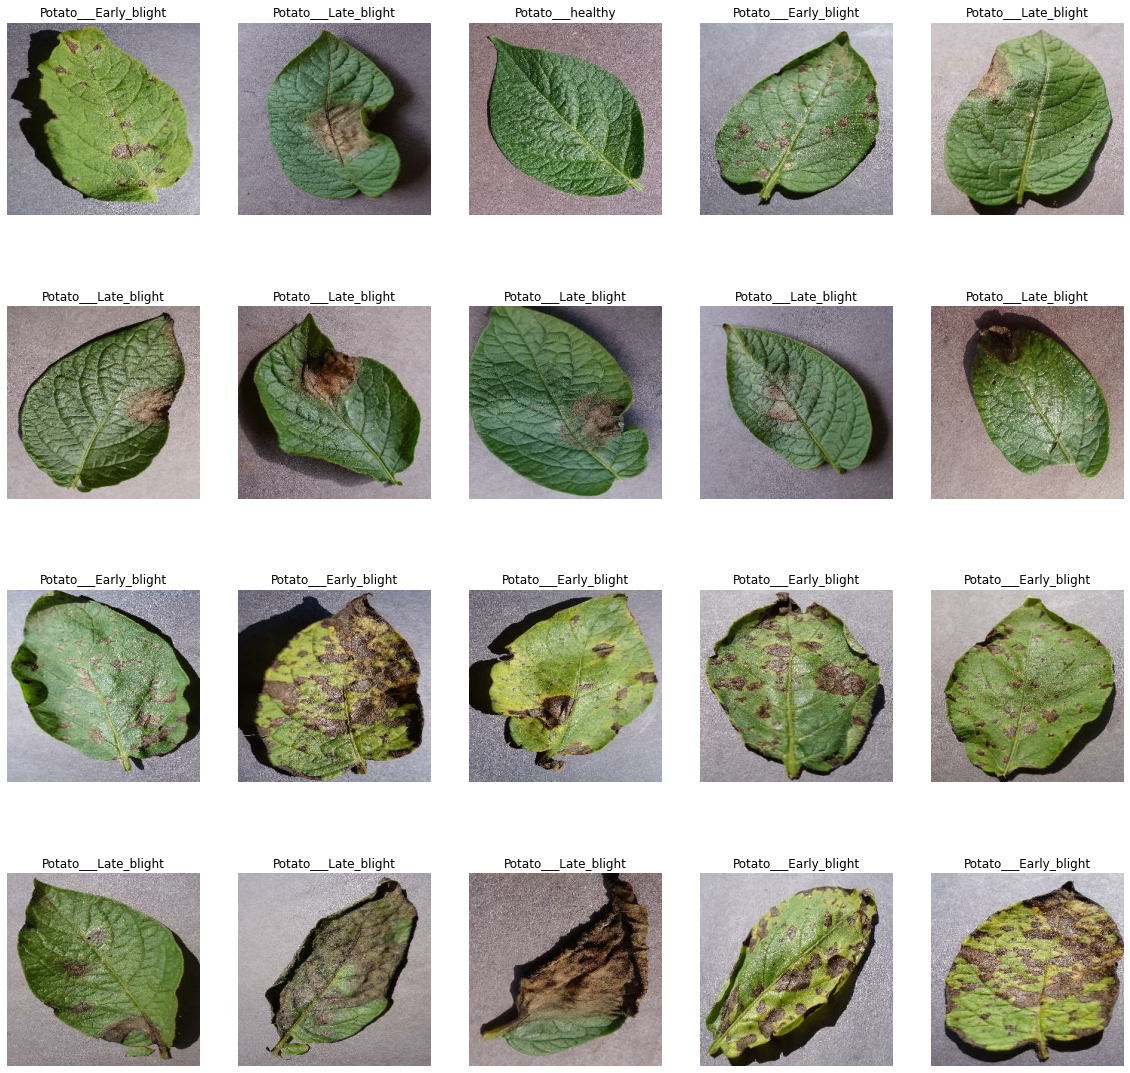

In [94]:
# showing some images
plt.figure(figsize=(20, 20))

for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> 10% validation, 10% test

## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [95]:
train_size = 0.8
train_size = int(len(dataset) * train_size)
train_size

54

In [96]:
# Separating training data
train_ds = dataset.take(train_size)
len(train_ds)

54

In [97]:
# Skipping train data
test_ds = dataset.skip(train_size)
len(test_ds)

14

In [98]:
# Getting validation data
val_size = 0.1
val_size = int(len(dataset)*val_size)

In [99]:
val_ds = test_ds.take(val_size)
len(val_ds)

6

In [100]:
test_df = test_ds.skip(val_size)
len(test_df)

8

In [101]:
# Function to perform dataset division in training, test and validation
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [102]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [103]:
print("train_ds =", len(train_ds))
print("val_ds =", len(val_ds))
print("test_ds =", len(test_ds))

train_ds = 54
val_ds = 6
test_ds = 8


## Cache, Shuffle, and Prefetch the Dataset

In [104]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [105]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(0.1 / 255)
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [106]:
data_argumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [107]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [108]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [109]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [110]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/5
54/54 [==============================] - 173s 3s/step - loss: 0.9157 - accuracy: 0.5237 - val_loss: 0.9275 - val_accuracy: 0.6927
Epoch 2/5
54/54 [==============================] - 140s 3s/step - loss: 0.6621 - accuracy: 0.7263 - val_loss: 0.4037 - val_accuracy: 0.8333
Epoch 3/5
54/54 [==============================] - 109s 2s/step - loss: 0.4382 - accuracy: 0.8310 - val_loss: 0.4566 - val_accuracy: 0.8385
Epoch 4/5
54/54 [==============================] - 101s 2s/step - loss: 0.4241 - accuracy: 0.8391 - val_loss: 0.3549 - val_accuracy: 0.8698
Epoch 5/5
54/54 [==============================] - 100s 2s/step - loss: 0.3742 - accuracy: 0.8576 - val_loss: 0.3215 - val_accuracy: 0.8802


In [111]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 462ms/step - loss: 0.3684 - accuracy: 0.8594


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [112]:
scores

[0.3683739900588989, 0.859375]

## Plotting the Accuracy and Loss Curves

In [113]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [114]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [115]:
type(history.history['loss'])

list

In [116]:
len(history.history['loss'])

5

In [117]:
# show Loss for first 5 epochs
history.history['loss'][:5]

[0.9156973361968994,
 0.662068247795105,
 0.4382150173187256,
 0.42405226826667786,
 0.374193400144577]

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

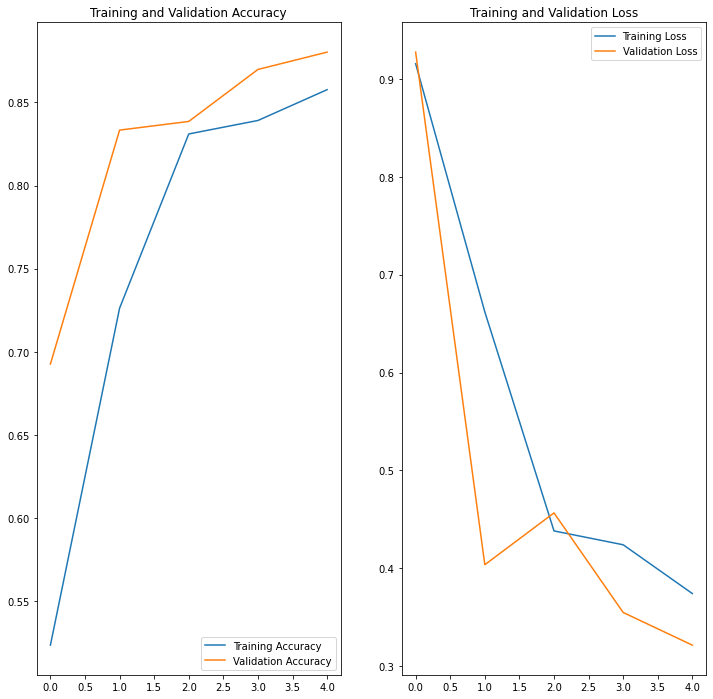

In [125]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 859ms/step
predicted label: Potato___Late_blight


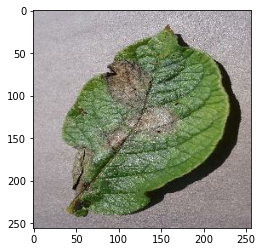

In [120]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [121]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference o few sample images**

1/1 [==============================] - 0s 62ms/step


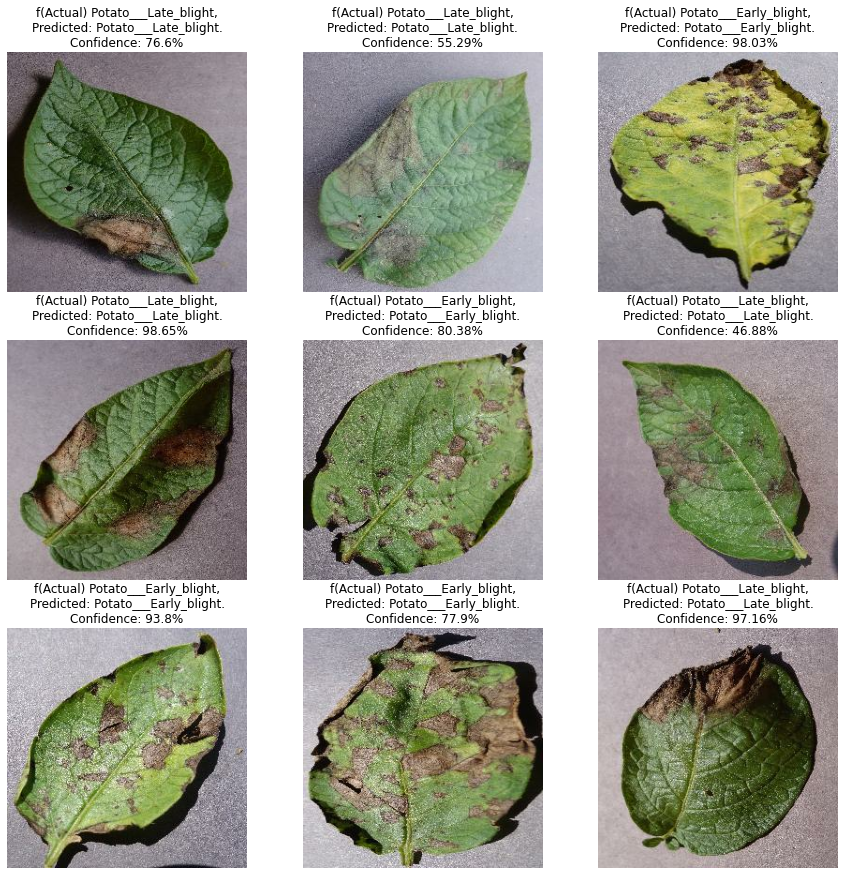

In [122]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'f(Actual) {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%')
        plt.axis('off')

# Saving the Model
We append the model to the list of models as a new version

In [123]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [124]:
model.save("../potatoes.h5")